In [1]:
### Try to replicate Daniel's methods:

import netCDF4
import numpy as np
import pandas
import glob
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from get_LWPCMIP5data import *
from get_LWPCMIP6data import *
from get_OBSLRMdata import *
from useful_func_cy import *
from fitLRM_cy1 import *
from fitLRM_cy2 import *

from fitLRMobs import *
from useful_func_cy import *
from calc_Radiation_LRM_1 import *
from calc_Radiation_LRM_2 import *

from area_mean import *
from binned_cyFunctions5 import *
from useful_func_cy import *

# OBServational constraint on the radiation and LWP:

from calc_LRMobs_metric import *

from calc_Radiation_OBS_2 import *
from Aploting_Sep11 import *
# import numpy as np


In [6]:
# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:
#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

path1 = '/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/'
path6 = '/glade/scratch/chuyan/Plots/CMIP_R_lwp/'

In [ ]:
# -----------------
# 'valid_range1' and 'valid_range2' give the time stamps of starting and ending times of data for training,
# 'valid_range3' and 'valid_range4' give the time stamps of starting and ending times of data for predicting.
# 's_range', 'x_range', 'y_range' is the latitude (Global), latitude (Southern Ocean), and longitude for 5 * 5 binned data;
# ------------------

# get the variables for training:
inputVar_training_obs = get_OBSLRM(valid_range1=valid_range1, valid_range2=valid_range2)

# get the variables for predicting:
inputVar_predict_obs = get_OBSLRM(valid_range1=valid_range3, valid_range2=valid_range4)

# As data dictionary:
datavar_nas = ['LWP', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']   #..7 varisables except gmt (lon dimension diff)
variable_MAC = ['LWP', 'LWP_error', 'Maskarray_mac']
variable_CERES = ['rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']

# Training Data processing:
# Liquid water path, Unit in kg m^-2
LWP_training = inputVar_training_obs['lwp'] / 1000.
# 1-Sigma Liquid water path statistic error, Unit in kg m^-2
LWP_error_training = inputVar_training_obs['lwp_error'] / 1000.
# the MaskedArray of 'MAC-LWP' dataset
Maskarray_mac_training = inputVar_training_obs['maskarray_mac']
# ---

# SW radiative flux:
Rsdt_training = inputVar_training_obs['rsdt']
Rsut_training = inputVar_training_obs['rsut']
Rsutcs_training = inputVar_training_obs['rsutcs']

albedo_training = Rsut_training / Rsdt_training
albedo_cs_training = Rsutcs_training / Rsdt_training
Alpha_cre_training = albedo_training - albedo_cs_training

# abnormal values:
albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan

dict0_training_var = {'LWP': LWP_training, 'LWP_error': LWP_error_training, 'Maskarray_mac': Maskarray_mac_training, 'rsdt': Rsdt_training, 'rsut': Rsut_training, 'rsutcs': Rsutcs_training, 'albedo' : albedo_training, 'albedo_cs': albedo_cs_training, 'alpha_cre': Alpha_cre_training, 'times': inputVar_training_obs['times_ceres']}

# Crop the regions
# crop the variables to the Southern Ocean latitude range: (40 ~ 85^o S)
dict1_SO_training, lat_so, lon_so = region_cropping(dict0_training_var, ['LWP', 'LWP_error', 'Maskarray_mac'], inputVar_training_obs['lat_mac'], inputVar_training_obs['lon_mac'], lat_range =[-85., -40.], lon_range = [-180., 180.])

dict1_SO_training['lat'] = lat_so
dict1_SO_training['lon'] = lon_so

# As data dictionary:
datavar_nas = ['LWP', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']   #..7 varisables except gmt (lon dimension diff)
variable_MAC = ['LWP', 'LWP_error', 'Maskarray_mac']
variable_CERES = ['rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']

# Predict Data processing:
# Liquid water path, Unit in kg m^-2
LWP_predict = inputVar_predict_obs['lwp'] / 1000.
# 1-Sigma Liquid water path statistic error, Unit in kg m^-2
LWP_error_predict = inputVar_predict_obs['lwp_error'] / 1000.
# the MaskedArray of 'MAC-LWP' dataset
Maskarray_mac_predict = inputVar_predict_obs['maskarray_mac']
# ---

# SW radiative flux:
Rsdt_predict = inputVar_predict_obs['rsdt']
Rsut_predict = inputVar_predict_obs['rsut']
Rsutcs_predict = inputVar_predict_obs['rsutcs']

albedo_predict = Rsut_predict / Rsdt_predict
albedo_cs_predict = Rsutcs_predict / Rsdt_predict
Alpha_cre_predict = albedo_predict - albedo_cs_predict

# abnormal values
albedo_cs_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
Alpha_cre_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan

dict0_predict_var = {'LWP': LWP_predict, 'LWP_error': LWP_error_predict, 'Maskarray_mac': Maskarray_mac_predict, 'rsdt': Rsdt_predict, 'rsut': Rsut_predict, 'rsutcs': Rsutcs_predict, 'albedo' : albedo_predict, 'albedo_cs': albedo_cs_predict, 'alpha_cre': Alpha_cre_predict, 'times': inputVar_predict_obs['times_ceres']}

# Crop the regions
# crop the variables to the Southern Ocean latitude range: (40 ~ 85^o S)
dict1_SO_predict, lat_so, lon_so = region_cropping(dict0_predict_var, ['LWP', 'LWP_error', 'Maskarray_mac'], inputVar_predict_obs['lat_mac'], inputVar_predict_obs['lon_mac'], lat_range =[-85., -40.], lon_range = [-180., 180.])

dict1_SO_predict['lat'] = lat_so
dict1_SO_predict['lon'] = lon_so

dict2_training_var = deepcopy(dict1_SO_training)
dict2_predict_var = deepcopy(dict1_SO_predict)

print('the first month in training period data: ', dict1_SO_training['times'][0,:][1]) # , dict1_SO_predict['times'][0,:][1])



(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)
 ended cropping 


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in less_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater_equal
/glade/u/ssg/ch/usr/jupyterhub/

 ended cropping 
the first month in training period data:  1.0


In [2]:
valid_range1=[2003, 1, 15]
valid_range2=[2016, 12, 31]
valid_range3=[2003, 1, 15]
valid_range4=[2004, 7, 31]


In [3]:
calc_LRMobs_metrics(valid_range1=valid_range1, valid_range2=valid_range2, valid_range3=valid_range3, valid_range4=valid_range4)

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_LRMobs_metric.py:147: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_LRMobs_metric.py:147: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_LRMobs_metric.py:148: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_LRMobs_metric.py:148: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan


 ended cropping 
 ended cropping 


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:175: RuntimeWarning: Mean of empty slice
  annually_array[i,:,:] = nanmean(dict_annually_mean[variable_nas[v]][i*12:(i+1)*12, :,:], axis = 0)


End monthly data binned.
End annually data binned.
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004]
Fill Value:  -999.0
(19, 45, 360)
Fill Value:  -999.0
(19, 45, 360)
Fill Value:  -999.0
(19, 45, 360)
 ended cropping 
 ended cropping 
End monthly data binned.
End annually data binned.
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
predictors metrix shape:  (4, 108864)
shape1:  (108864,)
shape2:  (1, 56451)
 Total # of regime 1
(4, 12312)
shape1:  (12312,)
shape2:  (1, 6505)
 Total # of regime 1
current # of regimes 0
cut-off folder ['/glade/scratch/chuyan/obs_output/OBS__STAT_pi+abr_22x_31y_Sep11th.npz']
TR_min_abs(bias):  284.5258187711201   K  -0.014617270429645265  Pa/s 
TR_large_pi_R_2:  283.9439510076129   K  0.004837945345928386  Pa/s 
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:721: RuntimeWarning: invalid value encountered in less_equal
  ind9 = X_dict['SUB'] <= cut_off2  # 'ind_up'
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:722: RuntimeWarning: invalid value encountered in greater
  ind10 = X_dict['SUB'] > cut_off2  # 'ind_down'
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:846: RuntimeWarning: invalid value encountered in less_equal
  ind9 = X_dict['SUB'] <= cut_off2   # 'ind_up'
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:847: RuntimeWarning: invalid value encountered in greater
  ind10 = X_dict['SUB'] > cut_off2   # 'ind_down'


(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
2.467680577625572 0.007279429781198931
0.6144370956950668 0.3677959376106875
predictors metrix shape:  (4, 108864)
shape1:  (108864,)
2LRM: HERE TR_sst =  0.6144370956950668 K
shape2:  (1, 56451)
 Total # of regime 2
(12312,)
shape1:  (12312,)
shape2:  (1, 6505)
 Total # of regime 2
current # of regimes 0
current # of regimes 1
(168, 9, 72)


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:429: RuntimeWarning: invalid value encountered in greater_equal
  ind_hot  = X_dict['SST'] >= cut_off1
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:430: RuntimeWarning: invalid value encountered in less
  ind_cold = X_dict['SST'] < cut_off1
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:523: RuntimeWarning: invalid value encountered in greater_equal
  ind_hot = X_dict['SST'] >= cut_off1
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:524: RuntimeWarning: invalid value encountered in less
  ind_cold = X_dict['SST'] < cut_off1


(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
(168, 9, 72)
2.467680577625572 0.007279429781198931
0.6144370956950668 0.3677959376106875
shape1:  (108864,)
shape2:  (1, 56451)
4LRM: HERE TR_sst =  0.6144370956950668 K
4LRM:  ... TR_sub =  0.3677959376106875 Pa s-1
shape7 and 8:  (1, 30596)  and  (1, 7194)
shape9 and 10:  (1, 11911)  and  (1, 6750)
 Total # of regime 4
shape1:  (12312,)
shape2:  (1, 6505)
 Total # of regime 4
current # of regimes 0
current # of regimes 1
current # of regimes 2
current # of regimes 3


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:635: RuntimeWarning: invalid value encountered in greater_equal
  ind_hot  = X_dict['SST'] >= cut_off1
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:636: RuntimeWarning: invalid value encountered in less
  ind_cold = X_dict['SST'] < cut_off1
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:638: RuntimeWarning: invalid value encountered in less_equal
  ind_up   = X_dict['SUB'] <= cut_off2
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:639: RuntimeWarning: invalid value encountered in greater
  ind_down = X_dict['SUB'] > cut_off2
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:813: RuntimeWarning: invalid value encountered in greater_equal
  ind_hot = X_dict['SST'] >= cut_off1
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/useful_func_cy.py:814: RuntimeWa

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004]
Fill Value:  -999.0
(19, 45, 360)
Fill Value:  -999.0
(19, 45, 360)
Fill Value:  -999.0
(19, 45, 360)
 ended cropping 
 ended cropping 


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:73: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:73: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:74: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:74: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs

the first month in training and predict data:  1.0 1.0
threshold =  0.12
 fration of not NaN points to All points in OBS trainingdata: 0.4014506172839506
 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4393.
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:45:46   Log-Likelihood:             1.3754e+05
No. Observations:               91049   AIC:                        -2.751e+05
Df Residuals:                   91047   BIC:                        -2.751e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1636.
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:45:46   Log-Likelihood:             1.7915e+05
No. Observations:              120677   AIC:                        -3.583e+05
Df Residuals:                  120675   BIC:                        -3.583e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1781.
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:45:46   Log-Likelihood:             1.8713e+05
No. Observations:              125463   AIC:                        -3.743e+05
Df Residuals:                  125461   BIC:                        -3.742e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     352.9
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           5.84e-78
Time:                        17:45:47   Log-Likelihood:                 25796.
No. Observations:               17350   AIC:                        -5.159e+04
Df Residuals:                   17348   BIC:                        -5.157e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:201: RuntimeWarning: invalid value encountered in greater_equal
  x[x >= np.nanpercentile(x, 95)] = np.nan


In [ ]:
# Choose time frame: January:
if dict1_SO_training['times'][0,:][1] == 2.0:   # Jan
    shape_mon_training_raw = dict1_SO_training['LWP'][0::12, :,:].shape   # January data shape
    for i in range(len(datavar_nas)):
        dict2_training_var[datavar_nas[i]] = dict1_SO_training[datavar_nas[i]][0::12, :, :]   # January data
else:
    shape_mon_training_raw = dict1_SO_training['LWP'][int(14 - dict1_SO_training['times'][0,:][1])::12, :,:].shape 
    for i in range(len(datavar_nas)):
        dict2_training_var[datavar_nas[i]] = dict1_SO_training[datavar_nas[i]][int(14 - dict1_SO_training['times'][0,:][1])::12, :, :]

if dict1_SO_predict['times'][0,:][1] == 2.0:   # Jan
    shape_mon_abr_raw = dict1_SO_predict['LWP'][0::12,:,:].shape   # January data shape
    for j in range(len(datavar_nas)):
        dict2_predict_var[datavar_nas[j]] = dict1_SO_predict[datavar_nas[j]][0::12, :, :]   # January data

else:
    shape_mon_abr_raw = dict1_SO_predict['LWP'][int(14 - dict1_SO_predict['times'][0,:][1])::12, :,:].shape 
    for j in range(len(datavar_nas)):
        dict2_predict_var[datavar_nas[j]] = dict1_SO_predict[datavar_nas[j]][int(14 - dict1_SO_predict['times'][0,:][1])::12, :, :]

# radiative transfer model: single regime 1.

# training :

x_training = 1.* dict2_training_var['LWP']

y2_training = 1.* dict2_training_var['alpha_cre']

y1_training = 1.* dict2_training_var['albedo']

cs_training = 1.* dict2_training_var['albedo_cs']

rsdt_training = 1.* dict2_training_var['rsdt']

# Filter threshold:
rsdt_training[rsdt_training < 10.0] = np.nan

cs_training[cs_training < 0.0] = np.nan
cs_training[y1_training > 0.39] = np.nan

Z_training = (rsdt_training * cs_training * x_training * y2_training * y1_training) *1.
ind_false_training = np.isnan(Z_training)
ind_true_training = np.logical_not(ind_false_training)

print(" ratio of not NaN value in Training data :" + str(np.asarray(np.nonzero(ind_true_training == True)).shape[1]/len(ind_true_training.flatten())))

data_training = pandas.DataFrame({'x': x_training[ind_true_training].flatten(), 'y2': y2_training[ind_true_training].flatten(), 'y1': y1_training[ind_true_training].flatten(), 'cs': cs_training[ind_true_training].flatten()})

# Fit the model
model1_training = ols("y2 ~ x", data_training).fit()
model2_training = ols("y1 ~ x + cs", data_training).fit()
# print the summary
print("model1_training, alpha_cre = a1 * lwp + A2: ", ' ', model1_training.summary())
print("model2_training, albedo = a1* lwp + a2 * albedo_cs + A3: ", ' ', model2_training.summary())

coef_array_alpha_cre_training = np.asarray([model1_training._results.params[1], model1_training._results.params[0]])
coef_array_albedo_training = np.asarray([model2_training._results.params[1], model2_training._results.params[2], model2_training._results.params[0]])

 ratio of not NaN value in Training data :0.30750440917107585
model1_training, alpha_cre = a1 * lwp + A2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                 2.344e+04
Date:                Tue, 04 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:21:02   Log-Likelihood:             1.4295e+05
No. Observations:               69742   AIC:                        -2.859e+05
Df Residuals:                   69740   BIC:                        -2.859e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [ ]:
albedo = np.array(data_training['y1'])
print(albedo)
ck_albedo = np.array(data_training['cs'])
print(ck_albedo)
lwp = np.array(data_training['x'])
print(lwp)

[0.51159424 0.51159424 0.4515528  ... 0.24919419 0.25100726 0.26208705]
[0.30952382 0.30952382 0.17130435 ... 0.09671636 0.09591056 0.09635375]
[0.05863737 0.04096019 0.04703876 ... 0.06907081 0.07005998 0.06934013]


Text(0.5, 1.0, 'OBS data: $\\ with\\ \\alpha \\leq 0.39 $')

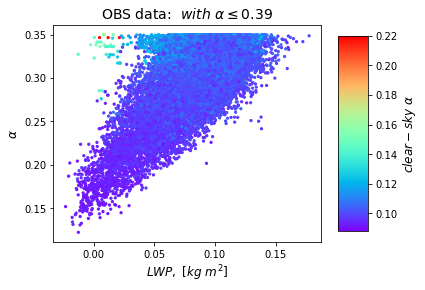

In [ ]:
# PLoting: density plots of albedo versus LWP:
from matplotlib import cm
fig = plt.figure()

ax1 = fig.add_subplot(111)
denc1=ax1.scatter(lwp[(albedo<= 0.35)],albedo[(albedo<= 0.35)],c=ck_albedo[(albedo<=0.35)],s = 5,cmap = cm.rainbow)

# denc1 = ax1.scatter(lwp[(ck_albedo>=0.13)& (ck_albedo<=0.16)], albedo[(ck_albedo>=0.13)& (ck_albedo<=0.16)], 
        # c = ck_albedo[(ck_albedo >=0.13)& (ck_albedo <=0.16)], s = 15,cmap = cm.rainbow)

ax1.set_xlabel("$LWP,\ [kg\ m^{2}]$", fontsize = 12)
ax1.set_ylabel(r"$\alpha $", fontsize = 12)
cb1 = fig.colorbar(denc1, shrink = 0.9, aspect = 6.5)
cb1.set_label(r"$clear-sky\ \alpha$", fontsize = 12)

plt.title("OBS data: " + r"$\ with\ \alpha \leq 0.39 $", fontsize = 14)  #  \alpha_{cs} \leq 0.12 ; 0.13 \leq \alpha_{cs} \leq 0.16

# plt.savefig(path6 + "CERES-albedo_MAC-LWP_coloredbyCERES-albedo_cs_albedole0.39.jpg", bbox_inches ='tight') # 

In [ ]:
c = (0.175)/ 0.15
print(c)

1.1666666666666667


# GCM albedo v.s. LWP, colored by albedo_cs Checks

# GCM's albedo v.s LWP ; albedo_cs fitting lines:

In [3]:
### Try to replicate Daniel's methods:

import netCDF4
import numpy as np
import pandas
import glob
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from get_LWPCMIP5data import *
from get_LWPCMIP6data import *
from get_OBSLRMdata import *
from useful_func_cy import *
from fitLRM_cy1 import *
from fitLRM_cy2 import *

from fitLRMobs import *
from useful_func_cy import *
from calc_Radiation_LRM_1 import *
from calc_Radiation_LRM_2 import *

from area_mean import *
from binned_cyFunctions5 import *
from useful_func_cy import *

In [4]:
# GCMs lists:

exp = 'piControl'

# CMIP6: 31 (30: BCCCSMCM2MR)
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCCSMCM2MR = {'modn': 'BCC-CSM2-MR', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
# HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
#             'exper': 'piControl', 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}   #..missing 'wap' in 'piControl' exp(Daniel says that HadGEM3-GC31 not using p-level, so doesn't have variables on p-level
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# CMIP5: 20 (18, ACCESS10, ACCESS13)

ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

MIROCESM = {'modn': 'MIROC-ESM', 'consort': 'MIROC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MRICGCM3 = {'modn': 'MRI-CGCM3', 'consort': 'MRI', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMLR = {'modn': 'MPI-ESM-LR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
bcccsm11 = {'modn': 'bcc-csm1-1', 'consort': 'BCC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2G = {'modn': 'GFDL-ESM2G', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2M = {'modn': 'GFDL-ESM2M', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
inmcm4 = {'modn': 'inmcm4', 'consort': 'INM', 'cmip': 'cmip5', 
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
deck2  = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM21, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0, E3SM10, FGOALSg3, GFDLCM4, CAMSCSM1, INM_CM48, MPIESM12LR, AWICM11MR, CMCCCM2SR5, CESM2WACCMFV2, CNRMCM61, CNRMCM61HR, ECEarth3, ECEarth3Veg, GISSE22G, MIROCES2L, NESM3, NorESM2MM, TaiESM1, BNUESM, CCSM4, CNRMCM5, CSIRO_Mk360, CanESM2, FGOALSg2, FGOALSs2, GFDLCM3, GISSE2H, GISSE2R, IPSLCM5ALR, MIROC5, MPIESMMR, NorESM1M, MIROCESM, MRICGCM3, MPIESMLR, bcccsm11, GFDLESM2G, GFDLESM2M]  #..current # 30 + 20

deck_nas2 = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM21', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0', 'E3SM10', 'FGOALSg3', 'GFDLCM4', 'CAMSCSM1', 'INM_CM48', 'MPIESM12LR', 'AWICM11MR', 'CMCCCM2SR5', 'CESM2WACCMFV2', 'CNRMCM61', 'CNRMCM61HR', 'ECEarth3', 'ECEarth3Veg', 'GISSE22G', 'MIROCES2L', 'NESM3', 'NorESM2MM', 'TaiESM1', 'BNUESM', 'CCSM4', 'CNRMCM5', 'CSIRO_Mk360', 'CanESM2', 'FGOALSg2', 'FGOALSs2', 'GFDLCM3', 'GISSE2H', 'GISSE2R', 'IPSLCM5ALR', 'MIROC5', 'MPIESMMR', 'NorESM1M', 'MIROCESM', 'MRICGCM3', 'MPIESMLR', 'bcccsm11', 'GFDLESM2G', 'GFDLESM2M']  #..current # 30 + 20 ('19': 'BCCCSMCM2MR';)



In [15]:
## Read two Regimes (Hot,Cold) data

output_ARRAY = {}   # storage output file
output_intermedia = {}   # storage the 'rawdata_dict'

output_dict0_PI = {}
output_dict0_abr = {}

output_GMT = {}
output_2lrm_predict = {}  # dict, store annualy, area_meaned prediction of LWP
output_2lrm_report = {}  # dict, store annually, area_meaned actual values of GCMs LWP
output_2lrm_coef_LWP = {}
output_2lrm_dict_albedo = {}  # Coefficients of 2 regimes's albedo trained by report 'LWP' data
# output_2lrm_coef_albedo_lL = {}

# Raw data
output_2lrm_yr_bin_abr = {}
output_2lrm_yr_bin_PI = {}
output_2lrm_mon_bin_abr = {}
output_2lrm_mon_bin_PI = {}

# Metric raw data in specific units:
shape_mon_pi = {}
shape_mon_abr = {}
output_2lrm_metric_actual_PI = {}
output_2lrm_metric_actual_abr = {}

# Statistic metrics of PI:
output_Mean_training = {}
output_Stdev_training = {}

# Predict metric data in specific units:
output_2lrm_mon_bin_LWPpredi_PI = {}
output_2lrm_mon_bin_LWPpredi_abr = {}
output_2lrm_DxDtG = {}

# Index for regime(s): Only for 2lrm
output_ind_Cold_PI = {}
output_ind_Hot_PI = {}
output_ind_Cold_abr = {}
output_ind_Hot_abr = {}

Tr_sst =  0.0

for i in range(len(deck2)):
    print("i", i)
    folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_Rtest' + '*' + '_dats.npz')
    print(len(folder_2lrm))
    if len(folder_2lrm) >2:
        if (len(folder_2lrm[1]) <  len(folder_2lrm[0])) & (len(folder_2lrm[1]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[0]) <  len(folder_2lrm[1])) & (len(folder_2lrm[0]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[0]
        else:
            folder_best2lrm = folder_2lrm[2]
        print(folder_best2lrm)
    elif len(folder_2lrm) != 1:
        if len(folder_2lrm[1]) <  len(folder_2lrm[0]):
            folder_best2lrm = folder_2lrm[1]
        else:
            folder_best2lrm = folder_2lrm[0]
        print(folder_best2lrm)
    
    else:
        output_ARRAY[deck_nas2[i]] = load(folder_2lrm[0], allow_pickle = True)  #+'_'+str(Tr_sst)
        print(folder_2lrm[0])
    
    output_ARRAY[deck_nas2[i]] =  load(folder_best2lrm, allow_pickle=True)  #+'_'+str(Tr_sst)

    # output_ARRAY[deck_nas2[i]] = load(folder_2lrm[0], allow_pickle = True)  #+'_'+str(Tr_sst)
    output_intermedia[deck_nas2[i]] = output_ARRAY[deck_nas2[i]]['rawdata_dict']
    
    output_GMT[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['GMT']
    output_2lrm_predict[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['predicted_metrics']
    output_2lrm_report[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['report_metrics']

    output_dict0_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_abr_var']
    
    output_2lrm_coef_LWP[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Coef_dict']
    output_2lrm_dict_albedo[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['coef_dict_Albedo_pi']
    
#     output_2lrm_DxDtG[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dX_dTg']
    
#     # Monthly data
#     output_2lrm_mon_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_mon_bin_PI']
#     output_2lrm_mon_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_mon_bin_abr']
#     # Annually data
#     output_2lrm_yr_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_yr_bin_PI']
#     output_2lrm_yr_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_yr_bin_abr']
    
#     # Flattened Metric monthly mean bin data
#     shape_mon_pi[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_PI_3']
#     shape_mon_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_abr_3']
#     output_2lrm_metric_actual_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_training']
#     output_2lrm_metric_actual_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_predict']
    
#     # Flattened Predicted monthly bin data
#     output_2lrm_mon_bin_LWPpredi_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_PI']
#     output_2lrm_mon_bin_LWPpredi_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_abr']
    
#     # Statistic metrics of PI:
#     output_Mean_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Mean_training']
#     output_Stdev_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Stdev_training']
    
#     # Indice for Regimes
#     output_ind_Hot_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_PI']
#     output_ind_Cold_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_PI']

#     output_ind_Hot_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_abr']
#     output_ind_Cold_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_abr']

print('Down read 2-LRM.')

i 0
0


IndexError: list index out of range

In [5]:
model_data = MRICGCM3 # MRICGCM3 CanESM5 CESM2


if model_data['cmip'] == 'cmip6':

    inputVar_pi, inputVar_abr = get_LWPCMIP6(**model_data)

elif model_data['cmip'] == 'cmip5':

    inputVar_pi, inputVar_abr = get_LWPCMIP5(**model_data)
else:
    
    print('not cmip6 & cmip5 data.')

# Radiation Change
# coef_array_alpha_cre_pi, coef_array_albedo_pi, coef_array_alpha_cre_abr, coef_array_albedo_abr = calc_Radiation_LRM_1(inputVar_pi, inputVar_abr, TR_albedo = 0.25)
# coef_array_alpha_cre_pi, coef_array_albedo_pi, coef_array_alpha_cre_abr, coef_array_albedo_abr = calc_Radiation_LRM_2(inputVar_pi, inputVar_abr)



# inputVar_pi, inputVar_abr are the data from read module: get_CMIP6data.py

#..get the shapes of monthly data
shape_lat = len(inputVar_pi['lat'])
shape_lon = len(inputVar_pi['lon'])
shape_time_pi = len(inputVar_pi['times'])
shape_time_abr = len(inputVar_abr['times'])
#print(shape_lat, shape_lon, shape_time_pi, shape_time_abr)


#..choose lat 40 -85 °S as the Southern-Ocean Regions
lons = inputVar_pi['lon'] *1.
lats = inputVar_pi['lat'][:] *1.

levels = np.array(inputVar_abr['pres'])
times_pi = inputVar_pi['times'] *1.
times_abr = inputVar_abr['times'] *1.

lati1 = -40.
latsi1 = min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))
lati0 = -85.
latsi0 = min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
print('lat index for -85S; -40S', latsi0, latsi1)

shape_latSO = (latsi1+1) - latsi0
print('shape of latitudinal index in raw data: ', shape_latSO)


# Read the Radiation data and LWP
# piControl and abrupt-4xCO2
# LWP
LWP_pi  = np.array(inputVar_pi['clwvi']) - np.array(inputVar_pi['clivi'])   #..units in kg m^-2
LWP_abr = np.array(inputVar_abr['clwvi']) - np.array(inputVar_abr['clivi'])   #..units in kg m^-2

# SW radiation metrics
Rsdt_pi = np.array(inputVar_pi['rsdt'])
Rsut_pi = np.array(inputVar_pi['rsut'])
Rsutcs_pi = np.array(inputVar_pi['rsutcs'])
print("shape of data in 'piControl':  ", Rsut_pi.shape, " mean 'piControl' upwelling SW radiation flux in the SO (Assume with cloud): "
, nanmean(Rsut_pi[:,latsi0:latsi1+1,:]))

Rsdt_abr = np.array(inputVar_abr['rsdt'])
Rsut_abr = np.array(inputVar_abr['rsut'])
Rsutcs_abr = np.array(inputVar_abr['rsutcs'])
print("shape of data in 'abrupt-4xCO2':  ",  Rsut_abr.shape, " mean 'abrupt-4xCO2' upwelling SW radiation flux in the SO (Assume with cloud): ",  nanmean(Rsut_abr[:,latsi0:latsi1+1,:]))

print(" mean |'abrupt-4xCO2' - 'piControl'| upwelling SW radiation flux (ALL-sky - Clear-sky) in the SO: ", 
      (nanmean(Rsut_abr[:,latsi0:latsi1+1,:] - Rsutcs_abr[:,latsi0:latsi1+1,:]) - nanmean(Rsut_pi[:,latsi0:latsi1+1,:] - Rsutcs_pi[:,latsi0:latsi1+1,:])))

# albedo, albedo_clear sky; albedo(alpha)_cre: all-sky - clear-sky
Albedo_pi = Rsut_pi / Rsdt_pi
Albedo_cs_pi = Rsutcs_pi / Rsdt_pi
Alpha_cre_pi = Albedo_pi - Albedo_cs_pi

Albedo_abr = Rsut_abr / Rsdt_abr
Albedo_cs_abr = Rsutcs_abr / Rsdt_abr
Alpha_cre_abr = Albedo_abr - Albedo_cs_abr
print(" mean |'abrupt-4xCO2' - 'piControl'| albedo (ALL-sky - Clear-sky) in the SO: ", 
      (nanmean(Alpha_cre_abr[:,latsi0:latsi1+1,:]) - nanmean(Alpha_cre_pi[:,latsi0:latsi1+1,:])))
# As data dictionary:
datavar_nas = ['LWP', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']   #..7 varisables except gmt (lon dimension diff)




dict0_PI_var = {'LWP': LWP_pi, 'rsdt': Rsdt_pi, 'rsut': Rsut_pi, 'rsutcs': Rsutcs_pi, 'albedo' : Albedo_pi, 'albedo_cs': Albedo_cs_pi, 'alpha_cre': Alpha_cre_pi, 'lat': lats, 'lon': lons, 'times': times_pi, 'pres': levels}

dict0_abr_var = {'LWP': LWP_abr, 'rsdt': Rsdt_abr, 'rsut': Rsut_abr, 'rsutcs': Rsutcs_abr, 'albedo': Albedo_abr, 'albedo_cs': Albedo_cs_abr, 'alpha_cre': Alpha_cre_abr, 'lat': lats, 'lon': lons, 'times': times_abr, 'pres': levels}

dict1_PI_var = deepcopy(dict0_PI_var)
dict1_abr_var = deepcopy(dict0_abr_var)

print('month in piControl and abrupt-4xCO2: ', times_pi[0,:][1], times_abr[0,:][1])

# Choose time frame: January
if times_pi[0,:][1] == 1.0:   # Jan
    shape_mon_PI_raw = dict0_PI_var['LWP'][0::12, latsi0:latsi1 +1,:].shape   # January data shape
    for i in range(len(datavar_nas)):
        dict1_PI_var[datavar_nas[i]] = dict1_PI_var[datavar_nas[i]][0::12, :, :]   # January data

else:
    shape_mon_PI_raw = dict0_PI_var['LWP'][int(13 - times_pi[0,:][1])::12, latsi0:latsi1 +1,:].shape 
    for i in range(len(datavar_nas)):
        dict1_PI_var[datavar_nas[i]] = dict1_PI_var[datavar_nas[i]][int(13 - times_pi[0,:][1])::12, :, :]

if times_abr[0,:][1] == 1.0:   # Jan
    shape_mon_abr_raw = dict0_abr_var['LWP'][0::12, latsi0:latsi1 +1,:].shape   # January data shape
    for j in range(len(datavar_nas)):
        dict1_abr_var[datavar_nas[j]] = dict1_abr_var[datavar_nas[j]][0::12, :, :]   # January data

else:
    shape_mon_abr_raw = dict0_abr_var['LWP'][int(13 - times_abr[0,:][1])::12, latsi0:latsi1 +1,:].shape 
    for j in range(len(datavar_nas)):
        dict1_abr_var[datavar_nas[j]] = dict1_abr_var[datavar_nas[j]][int(13 - times_abr[0,:][1])::12, :, :]


# Choose regional frame: SO (40 ~ 85 .S)
for c in range(len(datavar_nas)):
    dict1_PI_var[datavar_nas[c]] = dict1_PI_var[datavar_nas[c]][:,latsi0:latsi1+1, :]   # Southern Ocean data
    dict1_abr_var[datavar_nas[c]] = dict1_abr_var[datavar_nas[c]][:,latsi0:latsi1+1, :]  # Southern Ocean data

# radiative transfer model: single regime LRM:

# training (PI):

x_pi = 1.* dict1_PI_var['LWP']

y2_pi = 1.* dict1_PI_var['alpha_cre']

y1_pi = 1.* dict1_PI_var['albedo']

cs_pi = 1.* dict1_PI_var['albedo_cs']

rsdt_pi = 1.* dict1_PI_var['rsdt']

# Filter threshold:
rsdt_pi[rsdt_pi < 10.0] = np.nan

cs_pi[cs_pi < 0.0] = np.nan
cs_pi[cs_pi > 1.0] = np.nan

Z_PI = (rsdt_pi * cs_pi * x_pi * y2_pi * y1_pi) *1.
ind_false = np.isnan(Z_PI)
ind_true = np.logical_not(ind_false)

print(" ratio of not NaN value in Training data :" + str(np.asarray(np.nonzero(ind_true == True)).shape[1]/len(ind_true.flatten())))

data_pi = pandas.DataFrame({'x': x_pi[ind_true].flatten(), 'y2': y2_pi[ind_true].flatten(), 'y1': y1_pi[ind_true].flatten(), 'cs': cs_pi[ind_true].flatten()})

# Fit the model
model1_training_pi = ols("y2 ~ x", data_pi).fit()
model2_training_pi = ols("y1 ~ x + cs", data_pi).fit()
# print the summary
print("model1_training, alpha_cre = a1 * lwp + A2: ", ' ', model1_training_pi.summary())
print("model2_training, albedo = a1* lwp + a2 * albedo_cs + A3: ", ' ', model2_training_pi.summary())

coef_array_alpha_cre_pi = np.asarray([model1_training_pi._results.params[1], model1_training_pi._results.params[0]])
coef_array_albedo_pi = np.asarray([model2_training_pi._results.params[1], model2_training_pi._results.params[2], model2_training_pi._results.params[0]])
print(" The coef of albedo to lwp is: ", model2_training_pi._results.params[1])
# ******************************* #

MRI-CGCM3
1
/glade/scratch/chuyan/CMIP5data/
['/glade/scratch/chuyan/CMIP5data/pr_Amon_MRI-CGCM3_abrupt4xCO2_r1i1p1_185101-200012.nc']
 Variable pr   abrupt4xCO2
type of dataOUT in read_hs_file <class 'numpy.ma.core.MaskedArray'>
(1800, 160, 320)
retrieve time:  [1851, 1, 1] [2000, 12, 31]
MRI-CGCM3
1
/glade/scratch/chuyan/CMIP5data/
['/glade/scratch/chuyan/CMIP5data/ts_Amon_MRI-CGCM3_abrupt4xCO2_r1i1p1_185101-200012.nc']
 Variable ts   abrupt4xCO2
type of dataOUT in read_hs_file <class 'numpy.ma.core.MaskedArray'>
(1800, 160, 320)
MRI-CGCM3
1
/glade/scratch/chuyan/CMIP5data/
['/glade/scratch/chuyan/CMIP5data/ta_Amon_MRI-CGCM3_abrupt4xCO2_r1i1p1_190101-191012.nc', '/glade/scratch/chuyan/CMIP5data/ta_Amon_MRI-CGCM3_abrupt4xCO2_r1i1p1_185101-186012.nc', '/glade/scratch/chuyan/CMIP5data/ta_Amon_MRI-CGCM3_abrupt4xCO2_r1i1p1_191101-192012.nc', '/glade/scratch/chuyan/CMIP5data/ta_Amon_MRI-CGCM3_abrupt4xCO2_r1i1p1_187101-188012.nc', '/glade/scratch/chuyan/CMIP5data/ta_Amon_MRI-CGCM3_abrupt4xC

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


 mean |'abrupt-4xCO2' - 'piControl'| albedo (ALL-sky - Clear-sky) in the SO:  0.01693207
month in piControl and abrupt-4xCO2:  1.0 1.0
 ratio of not NaN value in Training data :1.0
model1_training, alpha_cre = a1 * lwp + A2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 3.232e+06
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:26:33   Log-Likelihood:             2.1872e+06
No. Observations:             1298880   AIC:                        -4.374e+06
Df Residuals:                 1298878   BIC:                        -4.374e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                        

In [6]:
albedo_gcm = np.array(data_pi['y1'])
print(albedo_gcm)
ck_albedo_gcm = np.array(data_pi['cs'])
print(ck_albedo_gcm)

lwp_gcm = np.array(data_pi['x'])
print(lwp_gcm)


[0.6740311 0.6740544 0.6740544 ... 0.2612526 0.2614168 0.2564192]
[0.6384575  0.6407004  0.6407004  ... 0.10474619 0.10485419 0.10455456]
[0.01025415 0.0117186  0.0117186  ... 0.1320115  0.1320115  0.0927847 ]


Text(0.5, 1.0, 'GCM: MRI-CGCM3$\\ with\\ \\alpha_{cs} \\leq 1.0 $')

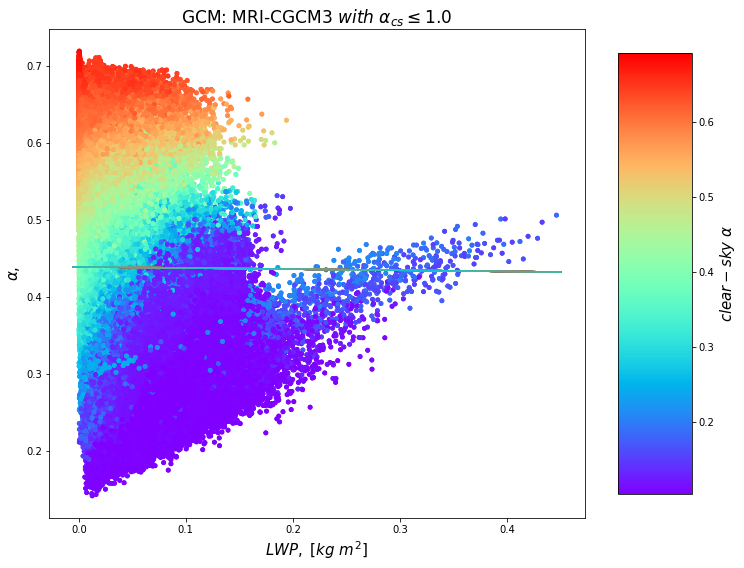

In [ ]:
# PLoting GCM: density plots of albedo versus LWP:
from matplotlib import cm
fig2 = plt.figure(figsize = (12, 9))
ax2 = fig2.add_subplot(111)

x = np.linspace(-0.005, 0.45, 50)
y = x
# scatter plot of specific gcm:
scac2 = ax2.scatter(lwp_gcm[(ck_albedo_gcm <= 1.0)],albedo_gcm[(ck_albedo_gcm<= 1.0)]
                          , c = ck_albedo_gcm[(ck_albedo_gcm<= 1.0)], s = 15, cmap = cm.rainbow)

# scac2=ax2.scatter(lwp_gcm[(ck_albedo_gcm>= 0.18)&(ck_albedo_gcm<= 0.25)],albedo_gcm[(ck_albedo_gcm>= 0.18)&(ck_albedo_gcm<= 0.25)]
                         # , c = ck_albedo_gcm[(ck_albedo_gcm>= 0.18)& (ck_albedo_gcm<= 0.25)],s = 15,cmap = cm.rainbow)

ax2.set_xlabel("$LWP,\ [kg\ m^{2}]$", fontsize = 15)
ax2.set_ylabel(r"$\alpha,\ $", fontsize = 15)
# cb2 = fig2.colorbar(scac2, shrink = 0.9, aspect = 6)
cb2.set_label(r"$clear-sky\ \alpha$", fontsize = 15)

# for i in range(len(deck2)):
#     ax2.plot(x, output_2lrm_coef_albedo[deck_nas2[40]][0]*x + output_2lrm_coef_albedo[deck_nas2[40]][1] * 0.1 + output_2lrm_coef_albedo[deck_nas2[40]][2], 
#                 label = deck2[40]['modn'])
# 
plt.title("GCM: " + model_data['modn'] + r"$\ with\ \alpha_{cs} \leq 1.0 $", fontsize = 17)  # \ 0.18 \leq \alpha_{cs} \leq 0.25\ 
# plt.show()
# plt.savefig(path6 + "GCM: " + model_data['modn']+"_albedo_LWP_coloredby_albedo_cs(0.18, 0.25).jpg", bbox_inches ='tight')


In [ ]:
for i in range(len(deck_nas2)):
    print('no. ' + str(i), deck2[i]['modn'])
    print(output_2lrm_coef_albedo[deck_nas2[i]])
    

no. 0 BCC-ESM1
[0.9542883  0.74914026 0.15846432]
no. 1 CanESM5
[1.37487431 0.80944422 0.13299744]
no. 2 CESM2
[0.78366394 0.67972395 0.20282604]
no. 3 CESM2-FV2
[1.01473667 0.71806505 0.1783985 ]
no. 4 CESM2-WACCM
[0.78138085 0.67495208 0.20703991]
no. 5 CNRM-ESM2-1
[1.46251257 0.77156104 0.16192184]
no. 6 GISS-E2-1-G
[0.53313655 0.73038269 0.19182252]
no. 7 GISS-E2-1-H
[0.54066775 0.73147355 0.18896095]
no. 8 IPSL-CM6A-LR
[0.48980024 0.6771924  0.22665011]
no. 9 MRI-ESM2-0
[0.71538006 0.71455402 0.18657837]
no. 10 MIROC6
[0.61844769 0.697451   0.19354611]
no. 11 SAM0-UNICON
[1.742932   0.72595626 0.18131026]
no. 12 E3SM-1-0
[1.48509349 0.73567122 0.1546893 ]
no. 13 FGOALS-g3
[1.10375711 0.78748224 0.13479483]
no. 14 GFDL-CM4
[1.04434299 0.69416664 0.21259666]
no. 15 CAMS-CSM1-0
[0.94312326 0.56856421 0.27134913]
no. 16 INM-CM4-8
[1.76493504 0.75488605 0.16808663]
no. 17 MPI-ESM1-2-LR
[0.51730696 0.58147124 0.30112389]
no. 18 AWI-CM-1-1-MR
[0.46239267 0.59180887 0.29177156]
no. 19 CMC

In [ ]:
N_of_model = 45
# model_data = deck2[N_of_model]
print('model ', deck2[N_of_model]['modn'])

WD = '/glade/scratch/chuyan/CMIP_output/'

folder = glob.glob(WD+ deck_nas2[N_of_model]+'__'+ 'STAT_pi+abr_'+'22x_31y_Sep9th_anomalies'+ '.npz')
# print(folder)
output_ARRAY = np.load(folder[0], allow_pickle=True)  # str(TR_sst)
TR_sst1 = output_ARRAY['TR_minabias_SST']
TR_sub1 = output_ARRAY['TR_minabias_SUB']
TR_sst2 = output_ARRAY['TR_maxR2_SST']
TR_sub2 = output_ARRAY['TR_maxR2_SUB']

print("TR_min_abs(bias): " , TR_sst1, '  K ', TR_sub1 , ' Pa/s ')
print("TR_large_pi_R_2: ", TR_sst2, '  K ', TR_sub2 , ' Pa/s ')

THRESHOLD_sst = TR_sst2
THRESHOLD_sub = TR_sub2

calc_LRM_metrics(float(TR_sst2), float(TR_sub2), **deck2[N_of_model])
# calc_LRM_metrics(float(0.0), float(0.0), **deck[N_of_model])



In [ ]:
# get variable data
if model_data['cmip'] == 'cmip6':

    inputVar_pi, inputVar_abr = get_LWPCMIP6(**model_data)

elif model_data['cmip'] == 'cmip5':

    inputVar_pi, inputVar_abr = get_LWPCMIP5(**model_data)
else:
    print('not cmip6 & cmip5 data.')

# ******************************* #
# Radiation Change
# coef_array_alpha_cre_pi, coef_array_albedo_pi, coef_array_alpha_cre_abr, coef_array_albedo_abr = calc_Radiation_LRM_1(inputVar_pi, inputVar_abr, TR_albedo = 0.25)
coef_dict_Alpha_cre_pi, coef_dict_Albedo_pi, coef_dict_Alpha_cre_abr, coef_dict_Albedo_abr = calc_Radiation_LRM_2(inputVar_pi, inputVar_abr,  **model_data)